## Classification with word2vec 

In [2]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

%matplotlib inline

## Load data

In [6]:
df = pd.read_csv('data/stack-overflow-data.csv', encoding = 'latin-1')

# only keep data that has a tag: 
df = df[pd.notnull(df['tags'])]
df.head(10)

,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c
3,.net framework 4 redistributable just wonderi...,.net
4,trying to calculate and print the mean and its...,python
5,how to give alias name for my website i have ...,asp.net
6,window.open() returns null in angularjs it wo...,angularjs
7,identifying server timeout quickly in iphone ...,iphone
8,unknown method key error in rails 2.3.8 unit ...,ruby-on-rails
9,from the include how to show and hide the con...,angularjs


In [7]:
# Count the number of words: 
df['post'].apply(lambda x: len(x.split(' '))).sum()

10286120

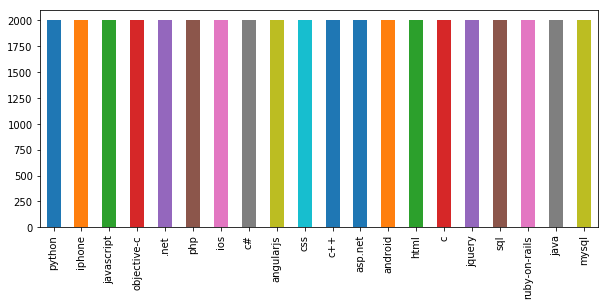

In [8]:
# defining our tags
my_tags = ['java','html','asp.net','c#','ruby-on-rails','jquery','mysql','php','ios','javascript','python','c','css','android','iphone','sql','objective-c','c++','angularjs','.net']

# visualising dataset
plt.figure(figsize=(10,4))
df.tags.value_counts().plot(kind='bar');

In [9]:
print(df['post'].values[1])

have dynamic html load as if it was in an iframe  i have an asp.net 4.0 site. users can save an entire html page into the backend database. what i want to do is load the dynamic content into a div on an existing page in a content area and have a couple of things to happen:    i do not want any of the css to affect anything outside the div  when first trying this out loading of some badly formed html would move images and other divs outside the content area around.    a lot of these html pages use the  base  tag for images and links  i want the base tag respected inside the div.    i have a solution that i am going to try which is just to use an iframe and set its url to another child page that loads the dynamic html into its own page entirely. i am just wondering if there is a better solution.


In [10]:
# note: slower students may wish to skip this step to finish the lab in class
nltk.download('stopwords')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
#     text = BeautifulSoup(text, features="xml").text
    text = BeautifulSoup(text, 'html.parser').text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

[nltk_data] Downloading package stopwords to /home/joel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
df['post'] = df['post'].apply(clean_text)

In [12]:
print(df['post'].values[1])

dynamic html load iframe aspnet 40 site users save entire html page backend database want load dynamic content div existing page content area couple things happen want css affect anything outside div first trying loading badly formed html would move images divs outside content area around lot html pages use base tag images links want base tag respected inside div solution going try use iframe set url another child page loads dynamic html page entirely wondering better solution


In [13]:
df['post'].apply(lambda x: len(x.split(' '))).sum()

3424194

In [14]:
print(df.shape)
df.head()

(40000, 2)


,post,tags
0,causing behavior c# datetime type test public ...,c#
1,dynamic html load iframe aspnet 40 site users ...,asp.net
2,convert float value minsec trying convert seco...,objective-c
3,net framework 4 redistributable wondering get ...,.net
4,trying calculate print mean returning rather n...,python


In [18]:
X = df.post
y = df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

### Logistic regression

Now that we have our features, we can train a classifier to try to predict the tag of a post. We will start with logistic, which provides a nice baseline for this task. 

To make the vectorizer => transformer => classifier easier to work with, we will use Pipeline class in Scilkit-Learn that behaves like a compound classifier.

### `TfidfTransformer`
Transform a count matrix to a normalized tf or tf-idf representation.

Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification.

The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report

logreg = Pipeline([('vect', CountVectorizer()), # Convert a collection of text documents to a matrix of token counts
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [20]:
%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7825
               precision    recall  f1-score   support

         java       0.70      0.63      0.66       613
         html       0.91      0.90      0.91       620
      asp.net       0.97      0.95      0.96       587
           c#       0.78      0.77      0.78       586
ruby-on-rails       0.77      0.81      0.79       599
       jquery       0.59      0.58      0.59       589
        mysql       0.77      0.75      0.76       594
          php       0.81      0.86      0.84       610
          ios       0.69      0.71      0.70       617
   javascript       0.61      0.59      0.60       587
       python       0.64      0.64      0.64       611
            c       0.82      0.83      0.83       594
          css       0.78      0.78      0.78       619
      android       0.84      0.84      0.84       574
       iphone       0.80      0.83      0.82       584
          sql       0.65      0.64      0.65       578
  objective-c       0.82      0.85      0.83    

### Notes on metrics
$Precision = \dfrac{True\,positive}{True\,positive\,+\,False\,positive}$

Precision is the ratio of `true positives` : `all predicted positives`. Tells us the fraction of correct predictions. Precision is a good measure to determine, when the costs of False Positive is high. For instance, email spam detection. In email spam detection, a false positive means that an email that is non-spam (actual negative) has been identified as spam (predicted spam). The email user might lose important emails if the precision is not high for the spam detection model.

$Recall = \dfrac{True\,positive}{True\,positive\,+\,False\,negative}$

Recall is the ratio of `true positives` : `total actual positives`. Tells us how many actual positives our model captured. Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative. For instance, in fraud detection or sick patient detection. If a fraudulent transaction (Actual Positive) is predicted as non-fraudulent (Predicted Negative), the consequence can be very bad for the bank.

$F1 = 2 \times \dfrac{Precision\,*\,Recall}{Precision\,+\,Recall}$

F1 Score is needed when you want to seek a balance between Precision and Recall. F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives).

### Word2vec embedding and Logistic Regression

In [3]:
%%time
from gensim.models import Word2Vec

wv = gensim.models.KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)
print('Model loaded')

Model loaded
CPU times: user 2min, sys: 2.67 s, total: 2min 3s
Wall time: 2min 5s


### Average the word vectors

In [17]:
def word_averaging(wv, words):
    # averages a set of words 'words' given their wordvectors 'wv'
    
    all_words, mean = set(), []
    
    for word in words:
        # if the words are alread vectors, then just append them
        if isinstance(word, np.ndarray):
            mean.append(word)
        # if not: first get the vector embedding for the words
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    
    if not mean:
        # error handling in case mean cannot be calculated
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    # use gensim's method to calculate the mean of all the words appended to mean list
    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [4]:
import nltk.data
nltk.download('punkt')

def w2v_tokenize_text(text):
    # create tokens, a list of words, for each post. This function will do some cleaning based on English language
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

[nltk_data] Downloading package punkt to /home/joel/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [15]:
train, test = train_test_split(df, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values

In [18]:
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

/home/joel/anaconda2/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  if sys.path[0] == '':


In [19]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['tags'])
y_pred = logreg.predict(X_test_word_average)

In [21]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, test.tags))
print(classification_report(test.tags, y_pred,target_names=my_tags))

accuracy 0.6375
               precision    recall  f1-score   support

         java       0.62      0.59      0.61       613
         html       0.74      0.76      0.75       620
      asp.net       0.65      0.67      0.66       587
           c#       0.53      0.52      0.52       586
ruby-on-rails       0.70      0.77      0.73       599
       jquery       0.44      0.39      0.41       589
        mysql       0.65      0.60      0.63       594
          php       0.73      0.80      0.76       610
          ios       0.60      0.61      0.60       617
   javascript       0.56      0.52      0.54       587
       python       0.55      0.50      0.52       611
            c       0.61      0.61      0.61       594
          css       0.65      0.65      0.65       619
      android       0.61      0.57      0.59       574
       iphone       0.70      0.71      0.71       584
          sql       0.42      0.43      0.43       578
  objective-c       0.68      0.70      0.69    

## References

* https://radimrehurek.com/gensim/models/word2vec.html
* https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568
* https://github.com/kavgan/nlp-text-mining-working-examples/tree/master/word2vec
* https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5